# Cleaning and Augmentation
This notebook is meant to read in the data downloaded from reddit and prepare it for analysis by cleaning it and doing some computation.

## Setup

In [1]:
import pandas as pd
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import collections

In [2]:
# Change this to analyze something else

# ## a big one:
# subreddit = "enlightenedbirdmen"
# download_date_string = "19.12.04-14:27:14"

# ## a meduim one:
# subreddit = "justwriterthings"
# download_date_string = "19.12.04-10:30:56"

## a small one:
subreddit = "The_B_Emoji"
download_date_string = "19.12.04-09:28:30"

In [3]:
# Constants
data_directory = "downloads/"
submissions_suffix = "-submissions-" + download_date_string + ".csv"
comments_suffix = "-comments-" + download_date_string + ".csv"

## Read the Data

In [4]:
# Read the submissions
submissions_file = data_directory + subreddit + submissions_suffix
submissions = pd.read_csv(submissions_file, index_col=0)
submissions.head()

,submission_id,user,utc,score,title,body,subreddit
0,e2yzip,greendirtbike,1.574953e+09,25,Yall 🅱️etter 🅱️e supporting local 🅱️usiness th...,They need to make a living just as much as the...,The_B_Emoji
1,e2nsue,ConnerFromCyberLife,1.574893e+09,36,🅱️he 🅱️ood 🅱️hit,NaN,The_B_Emoji
2,e0me00,Colteor,1.574536e+09,28,With 🅱️ you say?,NaN,The_B_Emoji
3,e07yk0,ConnerFromCyberLife,1.574459e+09,46,🅱️on’t 🅱️et 🅱️his 🅱️u🅱️reddit 🅱️ie,NaN,The_B_Emoji
4,dykruw,Colteor,1.574172e+09,28,🅱️,NaN,The_B_Emoji


In [5]:
# Read the comments
comments_file = data_directory + subreddit + comments_suffix
comments = pd.read_csv(comments_file, index_col=0)
comments.head()

,comment_id,submission_id,user,utc,score,body
0,f8yxtay,t3_e2yzip,skelly46,1.574954e+09,6,🅱️ye 🅱️ye 🅱️ig 🅱️usiness
1,f90phhs,t3_e2yzip,the_thou_factor,1.574976e+09,1,Jeff 🅱️ezos can suck my 🅱️ig cock. With the ne...
2,f90pgac,t3_e2yzip,Lapis-Blaze-Yt,1.574976e+09,0,I 🅱️re♿️er 🅱️🅾️mmunism
3,f8wlkrh,t3_e2nsue,Bored_Ford,1.574894e+09,5,"Oh 🅱️a🅱️y, that's 🅱️ank"
4,f8wlzva,t3_e2nsue,IPorK,1.574894e+09,4,Oh s🅱️it that's 🅱️eep


## Data Cleaning

In [6]:
# Remove the t3_ prefix from comment submission ids
comments["submission_id"] = comments["submission_id"].apply(lambda s: s.split("t3_")[1])

# Empty content should be the empty string - not nan
submissions['body'] = submissions['body'].fillna(value="")
comments['body'] = comments['body'].fillna(value="")

## Data Conversion

In [7]:
# Convert utc to date
submissions['date'] = submissions['utc'].apply(datetime.datetime.utcfromtimestamp)
comments['date'] = comments['utc'].apply(datetime.datetime.utcfromtimestamp)
#submissions.head()
comments.head()

,comment_id,submission_id,user,utc,score,body,date
0,f8yxtay,e2yzip,skelly46,1.574954e+09,6,🅱️ye 🅱️ye 🅱️ig 🅱️usiness,2019-11-28 15:18:39
1,f90phhs,e2yzip,the_thou_factor,1.574976e+09,1,Jeff 🅱️ezos can suck my 🅱️ig cock. With the ne...,2019-11-28 21:12:02
2,f90pgac,e2yzip,Lapis-Blaze-Yt,1.574976e+09,0,I 🅱️re♿️er 🅱️🅾️mmunism,2019-11-28 21:11:49
3,f8wlkrh,e2nsue,Bored_Ford,1.574894e+09,5,"Oh 🅱️a🅱️y, that's 🅱️ank",2019-11-27 22:27:08
4,f8wlzva,e2nsue,IPorK,1.574894e+09,4,Oh s🅱️it that's 🅱️eep,2019-11-27 22:32:03


In [37]:
# Ensure time ordering of submissions
submissions = submissions.sort_values(['date'], ascending = [1]).reset_index()

## Pagerank
This uses [networkx](https://networkx.github.io/documentation/networkx-1.10/index.html)

In [8]:
# # proff that directed edges are defined (start, end)
# d = nx.DiGraph()
# d.add_node(1)
# d.add_node(2)
# d.add_edge(1, 2)
# nx.draw_networkx(d)

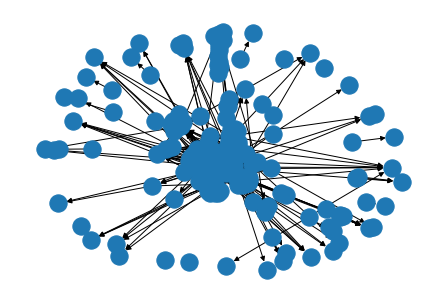

In [9]:
# Start by creating a directed graph
g = nx.DiGraph()

# Each user is a node in the graph
g.add_nodes_from(set(submissions['user'].append(comments['user'])))

# Each comment is a directed edge
pd.merge(submissions, comments, on='submission_id') \
    .apply(lambda row: g.add_edge(row["user_y"], row["user_x"]), axis=1)

# Visualize the graph
nx.draw(g)
plt.show()

In [10]:
# Now lets calculate pagerank
pagerank = nx.pagerank(g)
#pagerank # uncomment to preview

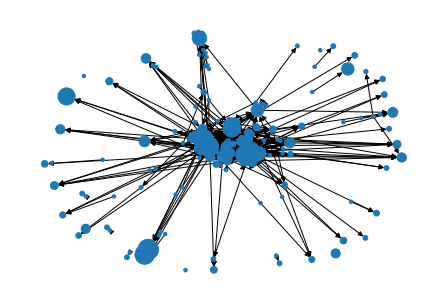

In [11]:
# and visualize it - 8000 is just a scaling factor to make the dots visible
nx.draw(g, node_size=[8000 * x for x in pagerank.values()])
plt.show()

## KLD

In [12]:
# scipy.special.kl_div([[1,2,3]], [[1,3,4],[2]])
submissions['content'] = submissions['body'] + submissions['title']
# submissions['content'] = 
def p_dist(content):
    words = content.split() # tokenize by splitting on whitespace
    counts = collections.Counter(words)
    total = sum(counts.values())
    return {word: count / total for word, count in counts.items()}
    
submissions['word_p_dist'] = submissions['content'].apply(p_dist)
submissions['entropy'] = submissions['word_p_dist'].apply(lambda d: scipy.stats.entropy(list(d.values()), base=2))

infinitesimal = 0.0001
# scipy.stats.entropy([0.25, 0.75, infinitesimal], [0.5, 0.4, 0.1], base=2)

In [40]:
def kld(word_freq1, word_freq2):
    if word_freq1 == None or word_freq2 == None:
        return np.nan
    p_dist1 = []
    p_dist2 = []
    for (word, freq) in word_freq1.items():
        p_dist1.append(freq)
        p_dist2.append(infinitesimal if not word in word_freq2 else word_freq2[word])
    for (word, freq) in word_freq2.items():
        if not word in word_freq1:
            p_dist1.append(infinitesimal)
            p_dist2.append(freq)
    return scipy.stats.entropy(p_dist1, p_dist2, base=2)
# kld({'a':0.25, 'b':0.75}, {'a':0.5, 'b':0.4, 'c':0.1})

In [45]:
# Calculate novelty
submissions['prev_submission_dist'] = submissions['word_p_dist'].shift(1).replace(to_replace={float("Nan"): None})
submissions['novelty'] = submissions.apply(lambda row: kld(row['word_p_dist'], row['prev_submission_dist']), axis=1)
submissions = submissions.drop('prev_submission_dist', axis=1)

## Grouping By Users

In [16]:
user_submissions = submissions.groupby("user").apply(lambda g: pd.Series(
    {
        'num_posts': g['title'].size,
        'max_score': g['score'].max(),
        'mean_score': g['score'].mean(),
        'min_score': g['score'].min(),
        'mean_length': g.apply(lambda row: len(row['title'] + row['body']), axis=1).mean(),
        'pagerank': pagerank[g['user'].iloc[0]] # weird indexing gets username and then finds pagerank for that user
    }
))
user_submissions.head()

,num_posts,max_score,mean_score,min_score,mean_length,pagerank
user,,,,,,
AirHamyes,1.0,24.0,24.000000,24.0,88.000000,0.006448
An_Und3adMann,1.0,10.0,10.000000,10.0,2.000000,0.001550
Andes1te,9.0,27.0,11.111111,4.0,52.444444,0.019543
Awesomeman235ify,1.0,4.0,4.000000,4.0,30.000000,0.007054
BluePharoh,3.0,57.0,23.666667,2.0,66.666667,0.011617


In [17]:
user_comments = comments.groupby("user").apply(lambda g: pd.Series(
    {
        'num_comments': g['body'].size,
        'max_score': g['score'].max(),
        'mean_score': g['score'].mean(),
        'min_score': g['score'].min(),
        'mean_length': g['body'].apply(len).mean(),
        'pagerank': pagerank[g['user'].iloc[0]] # weird indexing gets username and then finds pagerank for that user
    }
))
user_comments.head()

,num_comments,max_score,mean_score,min_score,mean_length,pagerank
user,,,,,,
-San-Holo-,1.0,1.0,1.000000,1.0,22.000000,0.001550
ATangerineMann,1.0,2.0,2.000000,2.0,7.000000,0.001550
Andes1te,6.0,3.0,2.333333,2.0,15.500000,0.019543
ArtaxYT,1.0,2.0,2.000000,2.0,9.000000,0.001550
Awesomeman235ify,3.0,2.0,1.333333,1.0,12.333333,0.007054


## Merging the Tables

In [18]:
users = user_submissions.join(user_comments, how="outer", lsuffix="_submissions", rsuffix="_comments")

## Clean up after the merge

# outer join means pagerank may only be defined in one case and not the other - combine them
users['pagerank'] = users.apply(lambda row: row['pagerank_comments'] if np.isnan(row['pagerank_submissions']) else row['pagerank_submissions'], axis=1)
users = users.drop('pagerank_submissions', axis=1)
users = users.drop('pagerank_comments', axis=1)
users.head()

,num_posts,max_score_submissions,mean_score_submissions,min_score_submissions,mean_length_submissions,num_comments,max_score_comments,mean_score_comments,min_score_comments,mean_length_comments,pagerank
user,,,,,,,,,,,
-San-Holo-,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.000000,1.0,22.0,0.001550
ATangerineMann,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.000000,2.0,7.0,0.001550
AirHamyes,1.0,24.0,24.000000,24.0,88.000000,NaN,NaN,NaN,NaN,NaN,0.006448
An_Und3adMann,1.0,10.0,10.000000,10.0,2.000000,NaN,NaN,NaN,NaN,NaN,0.001550
Andes1te,9.0,27.0,11.111111,4.0,52.444444,6.0,3.0,2.333333,2.0,15.5,0.019543


## EDA

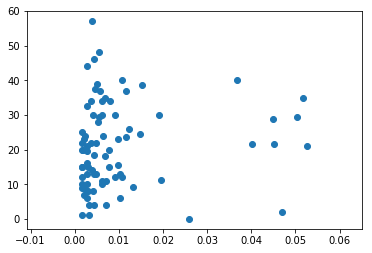

In [19]:
# mean score vs pagerank
plt.scatter(x=users['pagerank'], y=users['mean_score_submissions'])
plt.show()

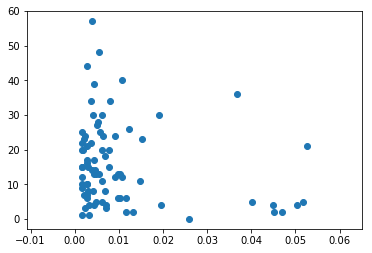

In [20]:
# min score vs pagerank
plt.scatter(x=users['pagerank'], y=users['min_score_submissions'])
plt.show()

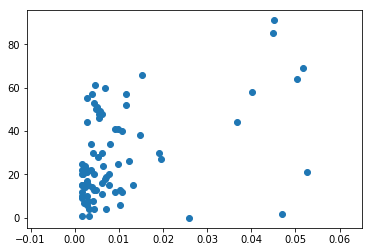

In [21]:
# max score vs pagerank
plt.scatter(x=users['pagerank'], y=users['max_score_submissions'])
plt.show()

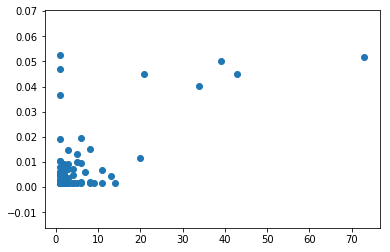

In [22]:
# number of comments vs pagerank
plt.scatter(x=users['num_comments'], y=users['pagerank'])
plt.show()

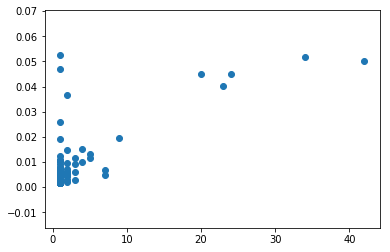

In [23]:
# number of posts vs pagerank - should be correlated (more submissions to comment on)
plt.scatter(x=users['num_posts'], y=users['pagerank'])
plt.show()
# okay, my hypothesis was wrong...

/home/mjkern/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mjkern/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


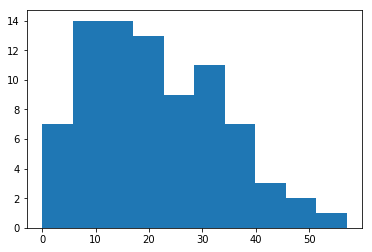

In [24]:
plt.hist(users['mean_score_submissions'])
plt.show()

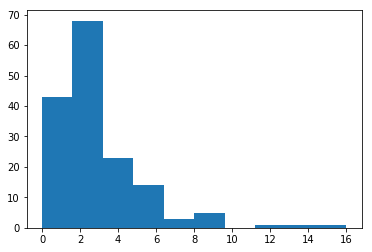

In [25]:
plt.hist(users['mean_score_comments'])
plt.show()

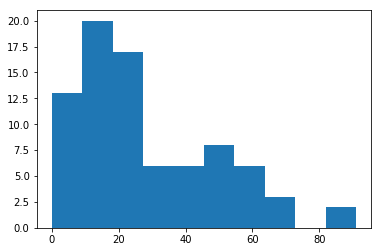

In [26]:
plt.hist(users['max_score_submissions'])
plt.show()

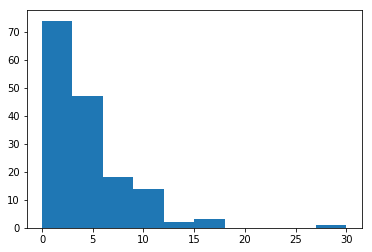

In [27]:
plt.hist(users['max_score_comments'])
plt.show()

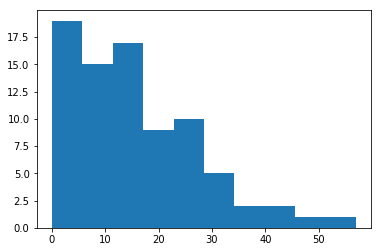

In [28]:
plt.hist(users['min_score_submissions'])
plt.show()

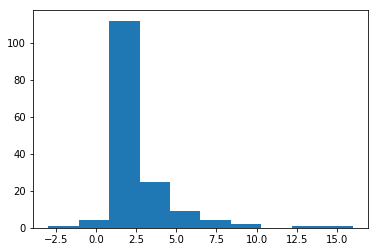

In [29]:
plt.hist(users['min_score_comments'])
plt.show()

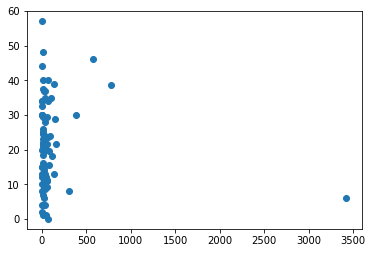

In [30]:
plt.scatter(x=users['mean_length_submissions'], y=users['mean_score_submissions'])
plt.show()

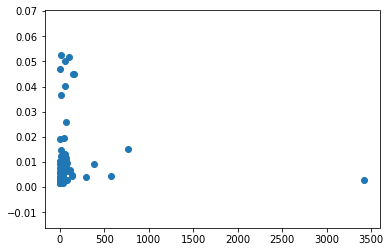

In [31]:
plt.scatter(x=users['mean_length_submissions'], y=users['pagerank'])
plt.show()

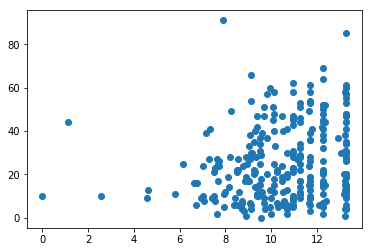

In [46]:
plt.scatter(x=submissions['novelty'], y=submissions['score'])